In [ ]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Image
import shap
import itertools

import scipy.stats
from copy import deepcopy
from pyfaidx import Fasta
fasta_seq=Fasta('/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta')
from pybedtools import BedTool
import os
import tensorflow as tf
import gc
from tqdm import tqdm
from seq2atac.stable import compute_gc_bed, one_hot_encode, plot_weights_given_ax
from seq2atac.stable.models.convolutional import get_bpnet_model
myround = lambda x:np.format_float_scientific(x, precision=2)
all_cancers = ['MELA', 'COAD', 'SKCM', 'READ', 'BRCA', 'LUAD', 'RECA', 'GBM', 'BLCA', 'KIRC', 'KIRP', 'BRCA_Lobular']
all_tcga_cancers = all_tcga_cancers = ["BRCA"] + [f"BRCA{x}" for x in range(10,26)]
sizesfile = "/illumina/scratch/deep_learning/akumar22/toymodel/master_files/hg38.chrom.sizes"


print(shap.__version__)
from kerasAC.interpret.deepshap import combine_mult_and_diffref_1d, create_background
from kerasAC.interpret.profile_shap import create_background_atac
from kerasAC.vis import plot_seq_importance

def get_gencode_tss(protein_coding_only=False):
    tss_file = "/illumina/scratch/deep_learning/akumar22/TCGA/mutations_scoring/master_files/gencode.v37.tss.tsv"
    tss_df = pd.read_csv(tss_file,sep="\t")
    
    if protein_coding_only:
        tss_df = tss_df[tss_df["transcript_type"].isin(["protein_coding"])].reset_index(drop=True)

    tss_df["end"] = tss_df["tss_pos"] + 1
    tss_df = tss_df[["chrom","tss_pos","end","gene"]].sort_values(["chrom","tss_pos"]).reset_index(drop=True)
    tss_df = tss_df[tss_df["gene"].apply(pd.isna) == 0]
    

    tss_df.columns = ["chr","start","end","gene"]
    return tss_df
cosmos_pancan_file = "/illumina/scratch/deep_learning/asalcedo/cancer_gene_census.csv"
cosmos_pancan_df = pd.read_csv(cosmos_pancan_file)
display(cosmos_pancan_df)
pancan_genes = cosmos_pancan_df[~cosmos_pancan_df["Role in Cancer"].isin(["fusion"])]["Gene Symbol"].tolist()
print(len(pancan_genes))
tss_df = get_gencode_tss()
tss_df_genelist = tss_df[tss_df["gene"].isin(pancan_genes)]

In [ ]:
def compute_shap_score(model,X_val):
    model_wrapper = (model.input, model.output)
    count_explainer=shap.DeepExplainer(model_wrapper,
                                       data=create_background,
                                       combine_mult_and_diffref=combine_mult_and_diffref_1d)
    
    count_explanations=count_explainer.shap_values(X_val)[0]
    return count_explanations 


def predict_classification_proba(X_val,model_fn,weights_files):
    
    preds_all = []
    for wts_file in weights_files:
        model = model_fn()
        model.load_weights(wts_file)
        ypreds = model.predict(X_val,batch_size=128).ravel()
        preds_all.append(ypreds)
    return np.mean(preds_all,axis=0)

def score_classification(X_val,model_fn,weights_files,scoring_fn):
    ## X_val is a single example (shape: 1,input_width,4)
    
    N,input_width,_ = X_val.shape
    score = np.zeros((N,input_width,4))
    for wts_file in weights_files:
        model = model_fn()
        model.load_weights(wts_file)
        
        score += scoring_fn(model,X_val)
    score /= len(weights_files)
    return score

In [ ]:
outdir = "/illumina/scratch/deep_learning/akumar22/TCGA/vignette/overlapping_non_ctcf_brca/"

In [ ]:
interesting_subset = pd.read_csv(f"{outdir}/master_dataframe.csv",index_col=0)
interesting_subset["index_in_np_array"] = list(range(len(interesting_subset)))
interesting_subset

In [5]:
score_dict_avshap = {}
for cancer_name in all_tcga_cancers:
    probs = np.load(f"{outdir}/proba_{cancer_name}_1299.npy")
    scores = np.load(f"{outdir}/score_{cancer_name}_1299.npy")
    score_dict_avshap[cancer_name] = (scores,probs)

In [6]:
### get pancan annotation for interesting_subset
interesting_bed = BedTool.from_dataframe(interesting_subset).sort()
interesting_bed_closest = interesting_bed.closest(BedTool.from_dataframe(tss_df_genelist), t="first", d=True)
interesting_bed_closest = pd.read_csv(interesting_bed_closest.fn,sep="\t",header=None)

old_names = list(interesting_bed_closest.columns)
new_names = list(interesting_subset.columns) + ["gene_chr","gene_start","gene_end","gene","distance_to_tss"]
old_to_new_names = dict(zip(old_names,new_names))
interesting_bed_closest=interesting_bed_closest.rename(columns=old_to_new_names)
assert len(interesting_subset) == len(interesting_bed_closest)
interesting_subset=interesting_subset.reset_index().merge(interesting_bed_closest,how="left").set_index("index")
interesting_subset

,chrom,start,end,num,list,BRCA,BRCA10,BRCA11,BRCA12,BRCA13,...,gc,ctcf,fos,jun,index_in_np_array,gene_chr,gene_start,gene_end,gene,distance_to_tss
index,,,,,,,,,,,,,,,,,,,,,
10,chr1,6199502,6199846,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.60,0.0,0.0,0.0,0,chr1,6199552,6199553,RPL22,0
29,chr1,17053987,17054355,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.57,0.0,0.0,0.0,1,chr1,17054006,17054007,SDHB,0
39,chr1,32179419,32179540,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.59,0.0,0.0,0.0,2,chr1,32251238,32251239,LCK,71699
44,chr1,35193051,35193487,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.56,0.0,0.0,0.0,3,chr1,35193144,35193145,SFPQ,0
62,chr1,50969975,50970032,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.56,0.0,0.0,0.0,4,chr1,50970244,50970245,CDKN2C,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,chrX,47217931,47218166,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.56,0.0,0.0,0.0,185,chrX,47179314,47179315,RBM10,38617
1272,chrX,47560891,47560946,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.55,0.0,0.0,0.0,186,chrX,47561204,47561205,ARAF,259
1285,chrX,53225260,53225725,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.55,0.0,0.0,0.0,187,chrX,53225421,53225422,KDM5C,0


In [7]:
for cancer_name in all_tcga_cancers:
    interesting_subset[f"{cancer_name}_proba"] = score_dict_avshap[cancer_name][1]
interesting_subset

,chrom,start,end,num,list,BRCA,BRCA10,BRCA11,BRCA12,BRCA13,...,BRCA16_proba,BRCA17_proba,BRCA18_proba,BRCA19_proba,BRCA20_proba,BRCA21_proba,BRCA22_proba,BRCA23_proba,BRCA24_proba,BRCA25_proba
index,,,,,,,,,,,,,,,,,,,,,
10,chr1,6199502,6199846,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.901034,0.655316,0.803566,0.574586,0.836309,0.659373,0.927450,0.824144,0.728755,0.889470
29,chr1,17053987,17054355,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.988855,0.964870,0.877894,0.891596,0.845077,0.900498,0.935020,0.877264,0.735491,0.711732
39,chr1,32179419,32179540,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.982201,0.953287,0.995317,0.966084,0.852935,0.936878,0.881327,0.972072,0.976808,0.975287
44,chr1,35193051,35193487,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.934662,0.747867,0.864413,0.870203,0.864585,0.668520,0.871547,0.871178,0.930956,0.851844
62,chr1,50969975,50970032,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.989386,0.887900,0.945903,0.527066,0.826998,0.760912,0.961626,0.826340,0.821894,0.905062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,chrX,47217931,47218166,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.984385,0.909864,0.989315,0.890422,0.995241,0.982571,0.937458,0.854535,0.987757,0.956203
1272,chrX,47560891,47560946,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.977755,0.957567,0.982540,0.921552,0.939849,0.821057,0.885891,0.813552,0.924928,0.891826
1285,chrX,53225260,53225725,17,"BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...",1,1,1,1,1,...,0.990514,0.987414,0.973090,0.789831,0.969341,0.928452,0.958734,0.851089,0.984175,0.924621


In [8]:
#### plot those which overlap a tss!
cool_subset = interesting_subset[(interesting_subset["gene"].isin(["RARA"]))]
print(cool_subset)

       chrom     start       end  num  \
index                                   
980    chr17  40417836  40418253   17   

                                                    list  BRCA  BRCA10  \
index                                                                    
980    BRCA,BRCA10,BRCA11,BRCA12,BRCA13,BRCA14,BRCA15...     1       1   

       BRCA11  BRCA12  BRCA13  ...  BRCA16_proba  BRCA17_proba  BRCA18_proba  \
index                          ...                                             
980         1       1       1  ...      0.958502      0.974359      0.983926   

       BRCA19_proba  BRCA20_proba  BRCA21_proba  BRCA22_proba  BRCA23_proba  \
index                                                                         
980        0.915583       0.95314      0.810645      0.946685      0.936138   

       BRCA24_proba  BRCA25_proba  
index                              
980        0.787577       0.83969  

[1 rows x 55 columns]


In [9]:
brca_type_map = ["LumA","HER2c","LumBc","HER2c","BASALc","LumA","BASAL","HER2+","HER2+","HER2","LumAc","HER2","LumBc","BASAL","BASALc","BASAL"]
brca_type_map = dict(zip([f"BRCA{x}" for x in range(10,26)],brca_type_map))
brca_type_map

{'BRCA10': 'LumA',
 'BRCA11': 'HER2c',
 'BRCA12': 'LumBc',
 'BRCA13': 'HER2c',
 'BRCA14': 'BASALc',
 'BRCA15': 'LumA',
 'BRCA16': 'BASAL',
 'BRCA17': 'HER2+',
 'BRCA18': 'HER2+',
 'BRCA19': 'HER2',
 'BRCA20': 'LumAc',
 'BRCA21': 'HER2',
 'BRCA22': 'LumBc',
 'BRCA23': 'BASAL',
 'BRCA24': 'BASALc',
 'BRCA25': 'BASAL'}

### get the scores

In [10]:
peak_informations = []
shifts_dict = {}
for idx_enumerator_i,(idx_inter,row_inter) in enumerate(cool_subset.iterrows()):
    print(idx_inter)

    align_chm,align_start,align_end = row_inter["chrom"], row_inter["start"], row_inter["end"]
    align_to = align_start


    
    ### for each cancer, get peaks... get their accuracy, get deepshap scores
    for cidx,cancer_name in enumerate(all_tcga_cancers):
        print(cancer_name)
        # set up plot
        mid_pt = 1364//2
        peakfile = f"/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/peaks_individuals/{cancer_name}_peakset.csv"
        if cancer_name == "BRCA":
            peakfile = "/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Cancerspecific_NewPeakset/BRCA_peakset.csv"

        peak_df = pd.read_csv(peakfile)[["seqnames","start","end"]]

        peakbed = BedTool.from_dataframe(peak_df)

        region = BedTool(f'{align_chm} {align_start} {align_end}', from_string=True)
        peak_intersect_df = peakbed.intersect(region,wa=True).to_dataframe()
        peak_intersect_df["sample_name"] = cancer_name
        peak_informations.append(peak_intersect_df)

        shift = align_to-peak_intersect_df.loc[0,"start"]
        shifts_dict[cancer_name] = shift

        idx,row = list(peak_intersect_df.iterrows())[0]
        chrom,start,end=row[:3]
        start = start - (1364-500)//2
        end = start + 1364
        X_val = one_hot_encode([str(fasta_seq[chrom][start:end])])

#         # compute score
#         idx_enumerator = row_inter["index_in_np_array"]
#         score1 = score_dict_avshap[cancer_name][0][[idx_enumerator]] * X_val
#         print(score1.shape)

#         np.save(f'brca_vignette_figure/{cancer_name}_scores.npy', score1)


980
BRCA
BRCA10
BRCA11
BRCA12
BRCA13
BRCA14
BRCA15
BRCA16
BRCA17
BRCA18
BRCA19
BRCA20
BRCA21
BRCA22
BRCA23
BRCA24
BRCA25


In [11]:
shifts_dict, shifts_dict.values()

({'BRCA': 67,
  'BRCA10': 71,
  'BRCA11': 44,
  'BRCA12': 51,
  'BRCA13': 78,
  'BRCA14': 2,
  'BRCA15': 57,
  'BRCA16': 0,
  'BRCA17': 14,
  'BRCA18': 81,
  'BRCA19': 61,
  'BRCA20': 33,
  'BRCA21': 83,
  'BRCA22': 10,
  'BRCA23': 50,
  'BRCA24': 61,
  'BRCA25': 78},
 dict_values([67, 71, 44, 51, 78, 2, 57, 0, 14, 81, 61, 33, 83, 10, 50, 61, 78]))

In [29]:
for cancer_name in all_tcga_cancers:
    sc = np.load(f"brca_vignette_figure/{cancer_name}_scores.npy")
    print(sc.shape)
    for row in sc[0]:
        if len(row[row!=0]) != 1 and row.sum() !=0:
            print(row)

(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)
(1, 1364, 4)


In [ ]:
!pwd

In [13]:
display(pd.concat(peak_informations))
pd.concat(peak_informations).to_csv("./brca_vignette_figure/coordinates.csv",index=None)

,chrom,start,end,sample_name
0,chr17,40417769,40418269,BRCA
0,chr17,40417765,40418265,BRCA10
0,chr17,40417792,40418292,BRCA11
0,chr17,40417785,40418285,BRCA12
0,chr17,40417758,40418258,BRCA13
0,chr17,40417834,40418334,BRCA14
0,chr17,40417779,40418279,BRCA15
0,chr17,40417836,40418336,BRCA16
0,chr17,40417822,40418322,BRCA17
0,chr17,40417755,40418255,BRCA18


In [14]:
#### get all the motifs in the region highlighted in the figure

In [15]:
all_peaks = pd.read_csv("./brca_vignette_figure/coordinates.csv")
all_peaks

,chrom,start,end,sample_name
0,chr17,40417769,40418269,BRCA
1,chr17,40417765,40418265,BRCA10
2,chr17,40417792,40418292,BRCA11
3,chr17,40417785,40418285,BRCA12
4,chr17,40417758,40418258,BRCA13
5,chr17,40417834,40418334,BRCA14
6,chr17,40417779,40418279,BRCA15
7,chr17,40417836,40418336,BRCA16
8,chr17,40417822,40418322,BRCA17
9,chr17,40417755,40418255,BRCA18


In [20]:
40417769 - 432

40417337

### generate the pdf figures

In [16]:
import matplotlib
plt.rcParams["figure.figsize"]=20,10
matplotlib.rcParams['pdf.fonttype']=42
!mkdir brca_vignette_figure/

mkdir: cannot create directory ‘brca_vignette_figure/’: File exists


980
BRCA



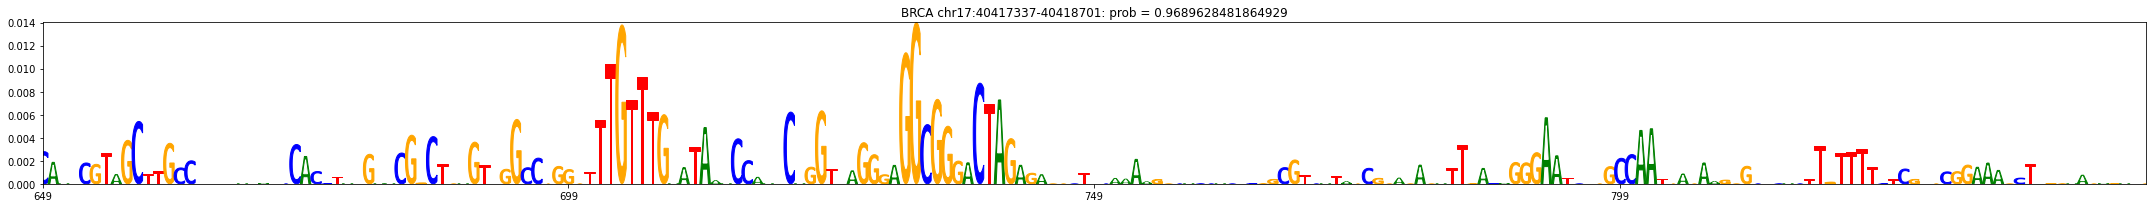

BRCA10



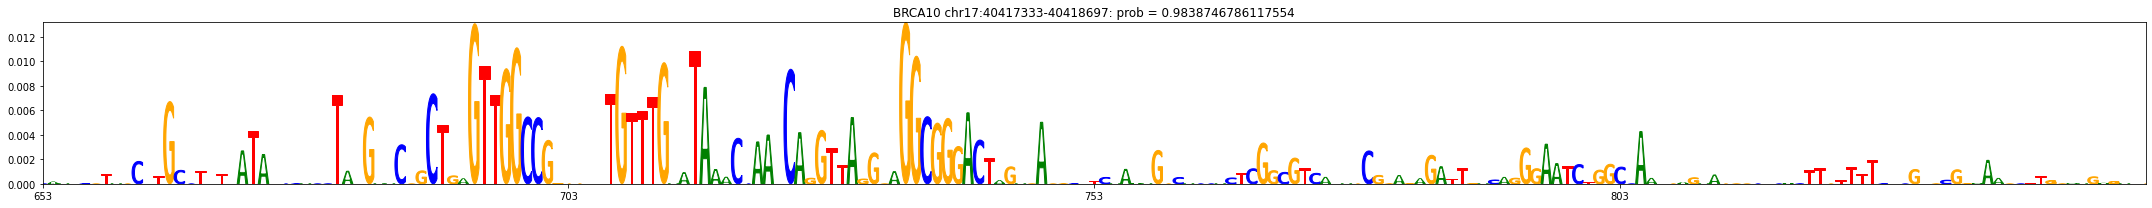

BRCA11



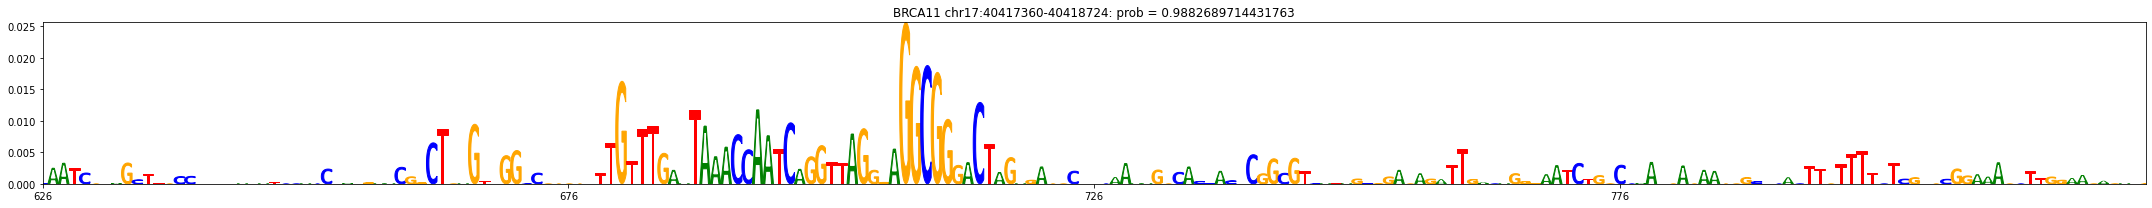

BRCA12



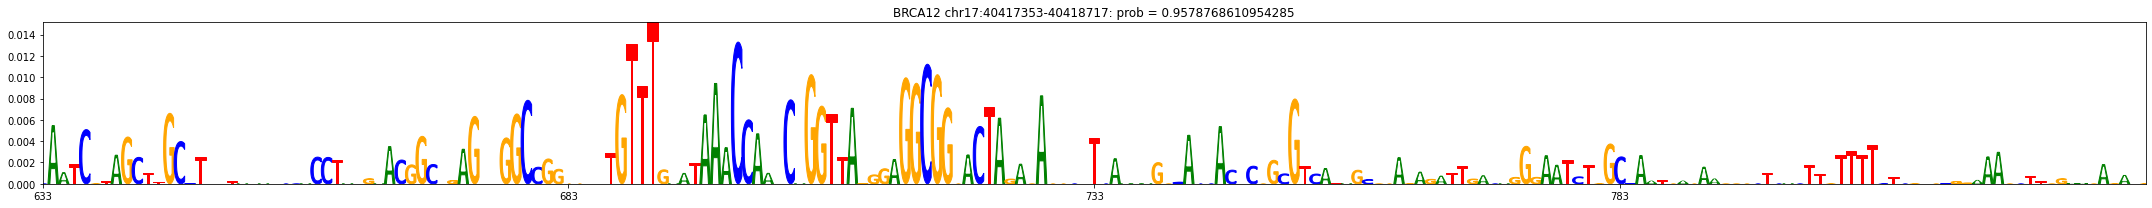

BRCA13



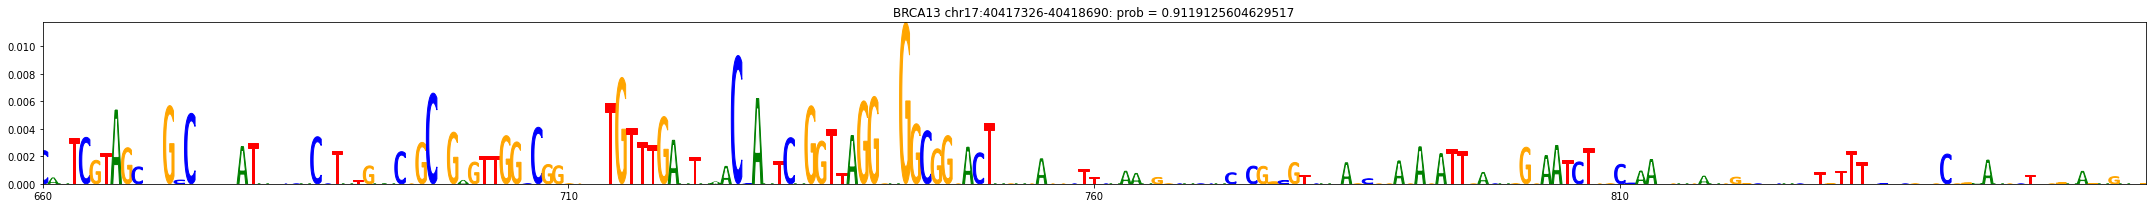

BRCA14



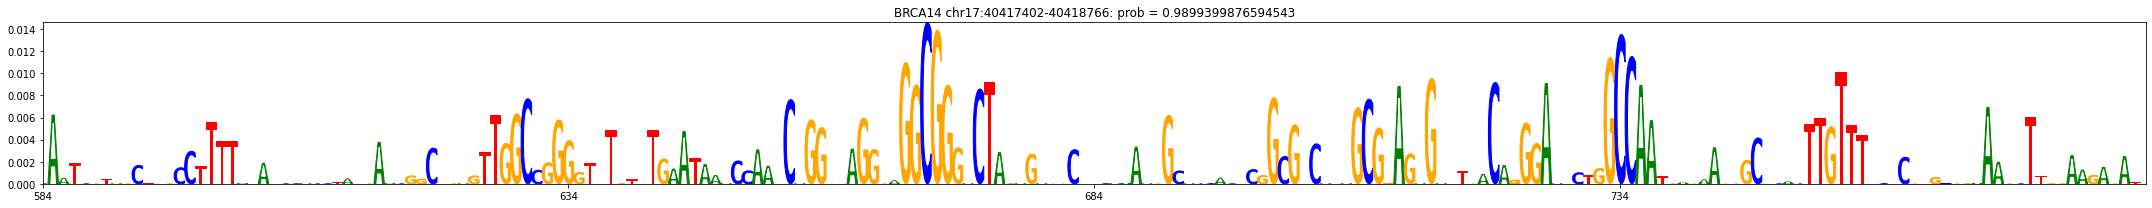

BRCA15



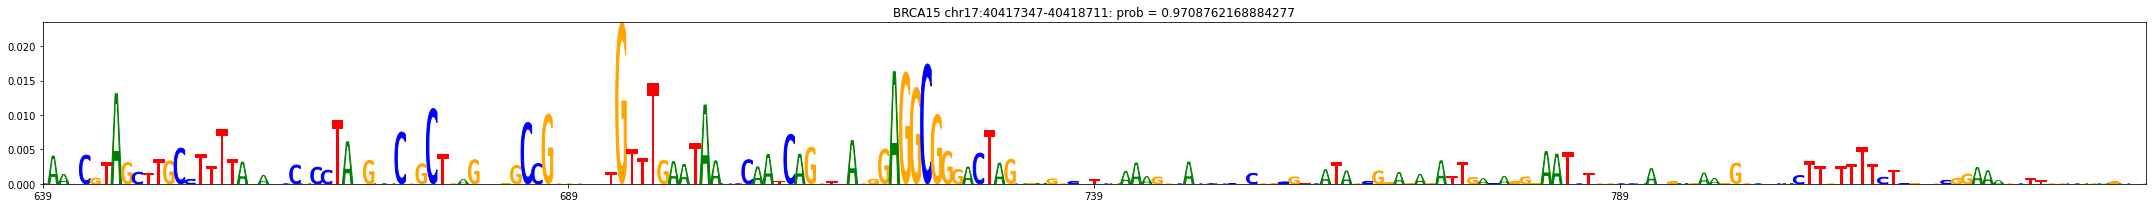

BRCA16



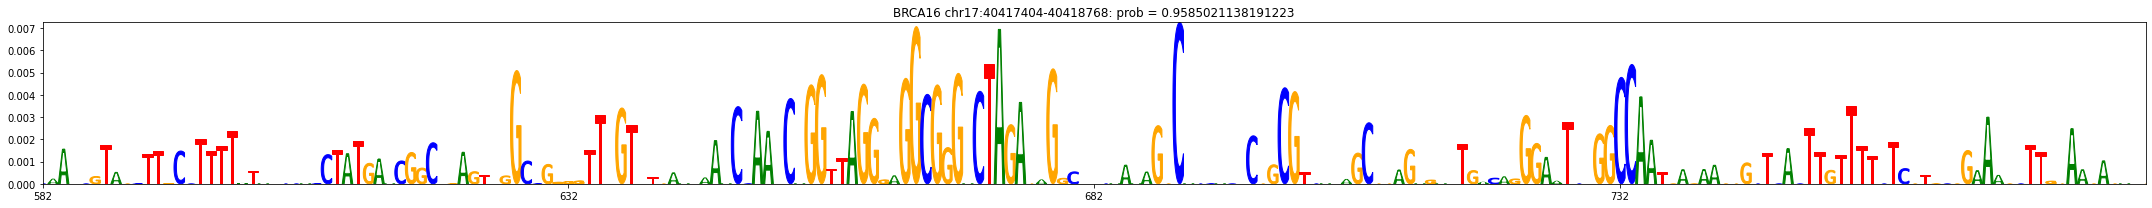

BRCA17



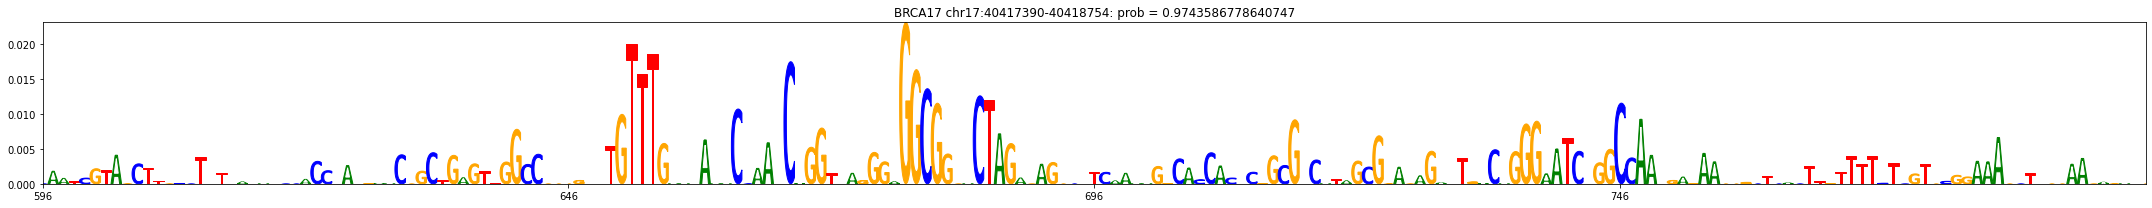

BRCA18



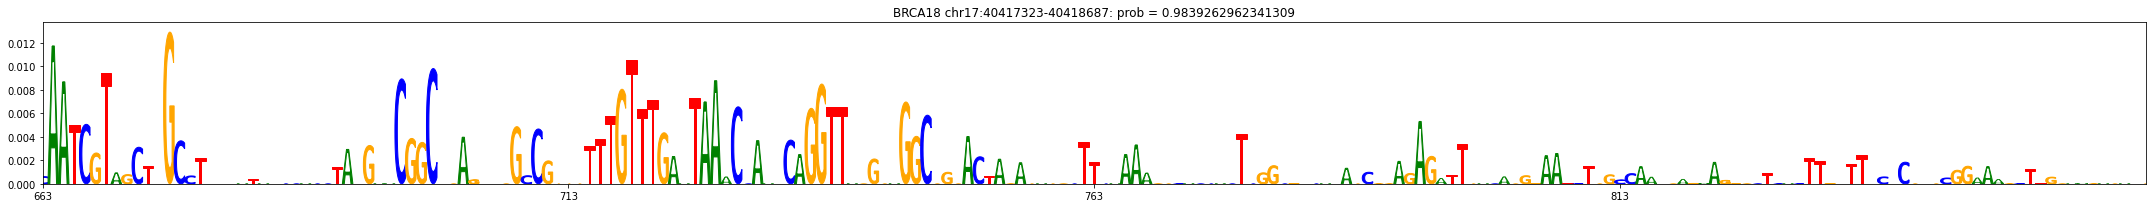

BRCA19



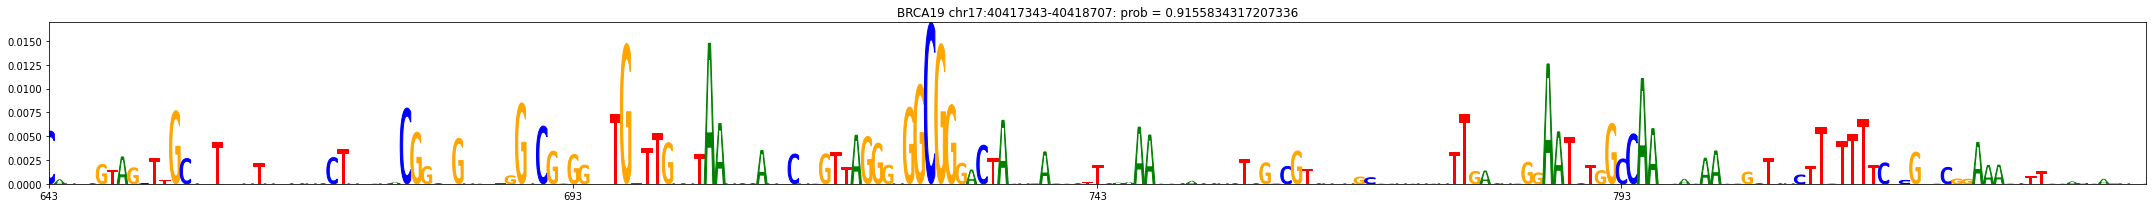

BRCA20



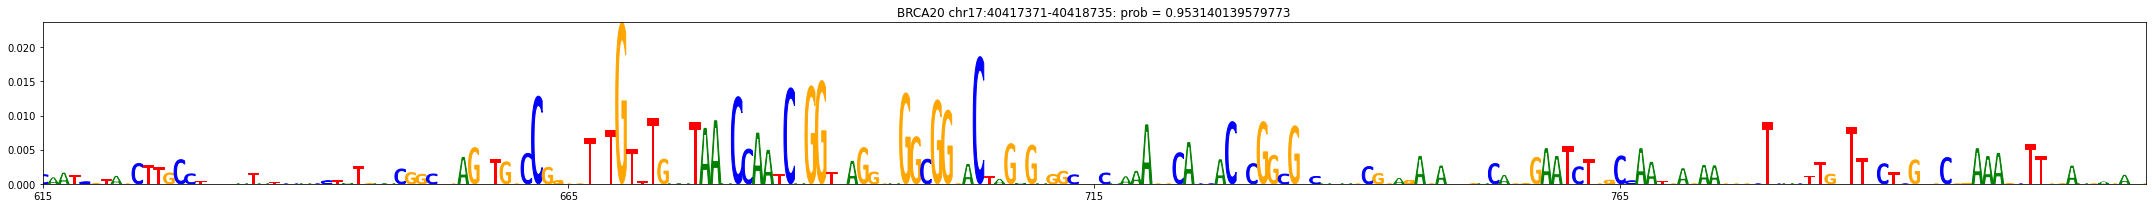

BRCA21



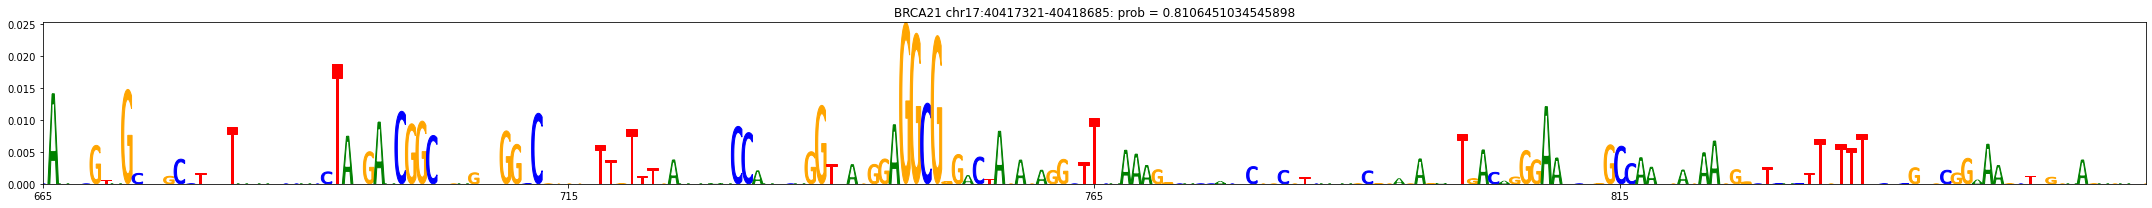

BRCA22



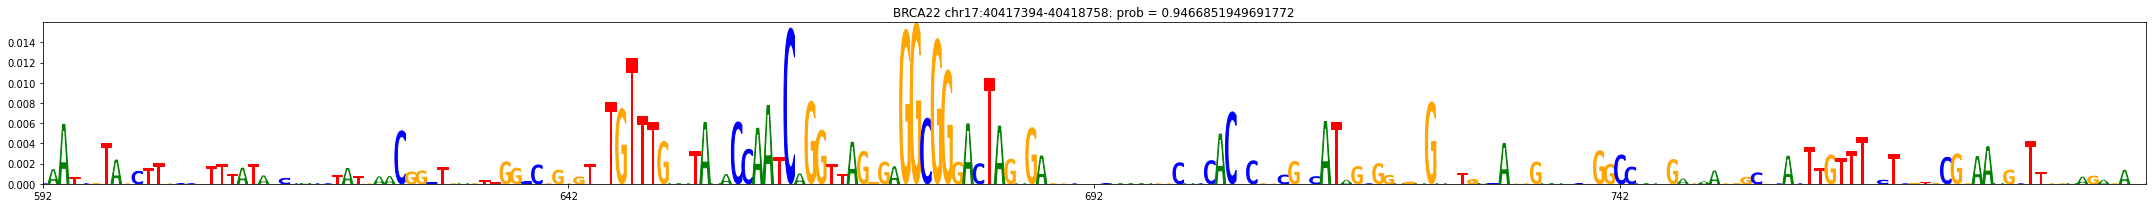

BRCA23



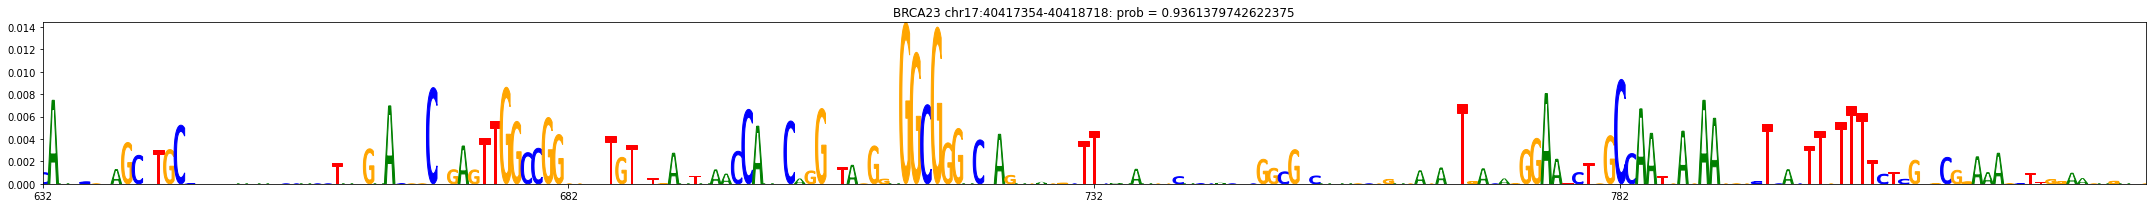

BRCA24



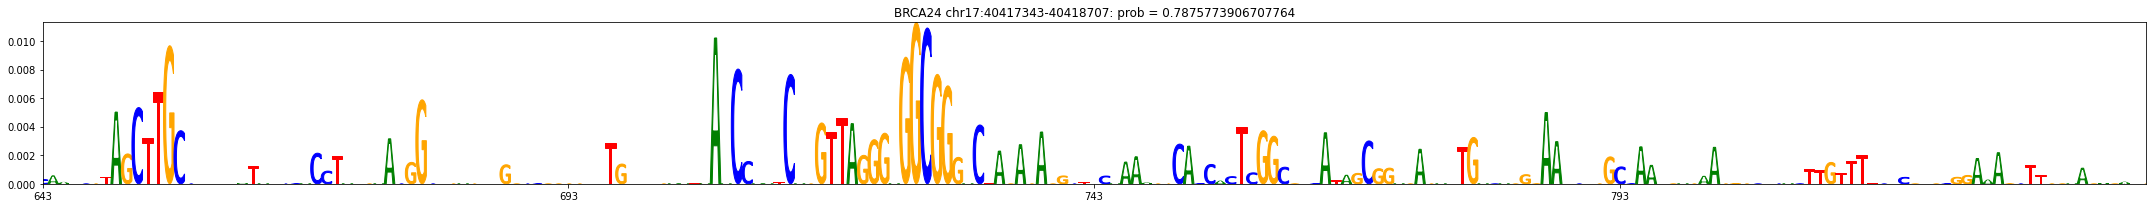

BRCA25



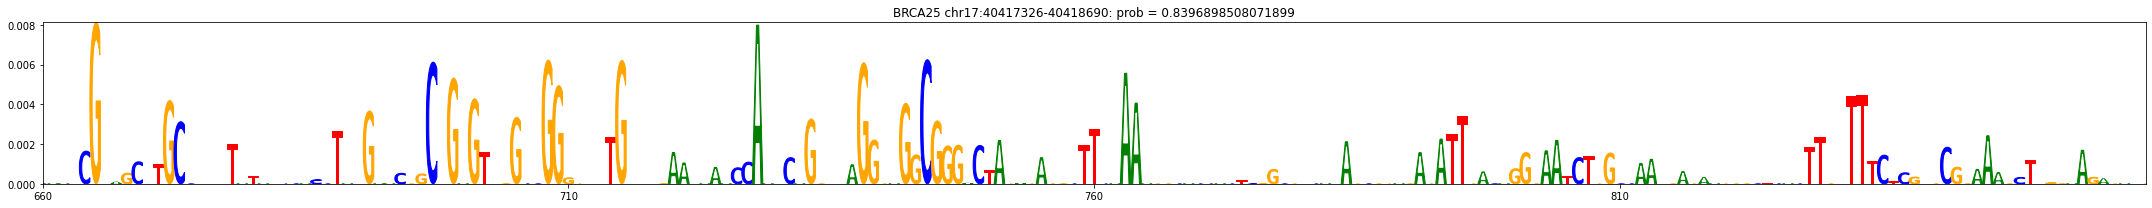

In [19]:
%matplotlib inline
for flank in [100]:
    for idx_enumerator_i,(idx_inter,row_inter) in enumerate(cool_subset.iterrows()):
        print(idx_inter)

        align_chm,align_start,align_end = row_inter["chrom"], row_inter["start"], row_inter["end"]
        align_to = align_start


        ### for each cancer, get peaks... get their accuracy, get deepshap scores
        for cidx,cancer_name in enumerate(all_tcga_cancers):
            print(cancer_name)
            # set up plot
            fig,axes = plt.subplots(figsize=(30*flank/100,3))
            mid_pt = 1364//2
            peakfile = f"/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/peaks_individuals/{cancer_name}_peakset.csv"
            if cancer_name == "BRCA":
                peakfile = "/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Cancerspecific_NewPeakset/BRCA_peakset.csv"

            peak_df = pd.read_csv(peakfile)[["seqnames","start","end"]]

            peakbed = BedTool.from_dataframe(peak_df)

            region = BedTool(f'{align_chm} {align_start} {align_end}', from_string=True)
            peak_intersect_df = peakbed.intersect(region,wa=True).to_dataframe()
            print()

            shift = align_to-peak_intersect_df.loc[0,"start"]


            idx,row = list(peak_intersect_df.iterrows())[0]
            chrom,start,end=row[:3]
            start = start - (1364-500)//2
            end = start + 1364
            X_val = one_hot_encode([str(fasta_seq[chrom][start:end])])

            plt_start = mid_pt-flank+shift
            plt_end = mid_pt+flank+shift

            # compute score
            idx_enumerator = row_inter["index_in_np_array"]
            score1 = score_dict_avshap[cancer_name][0][[idx_enumerator]] * X_val
            # plot importance
            # plot_weights_given_ax(axes[cidx],score1[0][plt_start:plt_end], subticks_frequency=20)
            axes = plot_seq_importance(score1,X_val,xlim=(plt_start,plt_end),axes=axes)
            prob_recalc = row_inter[f"{cancer_name}_proba"]
            axes.set_title(f"{cancer_name} {chrom}:{start}-{end}: prob = {prob_recalc}")

            ymax = score1[0][1364//2-250:1364//2+250].max()
            ymin = score1[0][1364//2-250:1364//2+250].min()
            axes.set_ylim(0,ymax)

            fig.tight_layout()
#             plt.show()
            plt.savefig(f'brca_vignette_figure/{cancer_name}_{flank*2}.pdf',dpi=1200)


In [5]:
fasta_seq["chr17"][40418017:40418066]

NameError: name 'fasta_seq' is not defined

In [ ]:
for flank in [500]:
    for idx_enumerator_i,(idx_inter,row_inter) in enumerate(cool_subset.iterrows()):
        print(idx_inter)

        align_chm,align_start,align_end = row_inter["chrom"], row_inter["start"], row_inter["end"]
        align_to = align_start


        ### for each cancer, get peaks... get their accuracy, get deepshap scores
        for cidx,cancer_name in enumerate(["C6","C8"]):
            print(cancer_name)
            # set up plot
            fig,axes = plt.subplots(figsize=(30*flank/100,3))
            mid_pt = 1364//2
            peakfile = f"/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/ArchR_Projects/controls/breast_control_Archr/{cancer_name}_allpeaks.csv"

            peak_df = pd.read_csv(peakfile)[["seqnames","start","end"]]

            peakbed = BedTool.from_dataframe(peak_df)

            region = BedTool(f'{align_chm} {align_start} {align_end}', from_string=True)
            peak_intersect_df = peakbed.intersect(region,wa=True).to_dataframe()

            shift = align_to-peak_intersect_df.loc[0,"start"]


            idx,row = list(peak_intersect_df.iterrows())[0]
            chrom,start,end=row[:3]
            start = start - (1364-500)//2
            end = start + 1364
            X_val = one_hot_encode([str(fasta_seq[chrom][start:end])])

            plt_start = mid_pt-flank+shift
            plt_end = mid_pt+flank+shift

            # compute score
            model_fn = lambda : get_bpnet_model(1364,8)
            weights_files = glob.glob(f"/illumina/scratch/deep_learning/akumar22/TCGA/models_250_1364_minibatch_prejitter/breast_control/{cancer_name}/fold_*/model.h5")
            score1 = score_classification(X_val, model_fn, weights_files, compute_shap_score) * X_val
            # plot importance
            # plot_weights_given_ax(axes[cidx],score1[0][plt_start:plt_end], subticks_frequency=20)
            axes = plot_seq_importance(score1,X_val,xlim=(plt_start,plt_end),axes=axes)
            prob_recalc = row_inter[f"{cancer_name}_proba"]
            axes.set_title(f"{cancer_name} {chrom}:{start}-{end}: prob = {prob_recalc}")

            ymax = score1[0][1364//2-250:1364//2+250].max()
            ymin = score1[0][1364//2-250:1364//2+250].min()
            axes.set_ylim(0,ymax)

            fig.tight_layout()
            plt.savefig(f'brca_vignette_figure/{cancer_name}_{flank*2}.pdf',dpi=1200)


### to plot the vignette

In [ ]:
ordered_cancers = ["BRCA"] + [f"BRCA{x}" for x in [10,12,15,20,22,14,16,23,24,25,11,13,17,18,19,21]]
for idx_enumerator_i,(idx_inter,row_inter) in enumerate(cool_subset.iterrows()):
    print(idx_inter)
    
    align_chm,align_start,align_end = row_inter["chrom"], row_inter["start"], row_inter["end"]
    align_to = align_start

    # set up plot
    fig,axes = plt.subplots(17,1,figsize=(30,24))
    axes=axes.ravel()
    mid_pt = 1364//2
    flank=100

    ### for each cancer, get peaks... get their accuracy, get deepshap scores
    for cidx,cancer_name in enumerate(ordered_cancers):
        print(cancer_name)
        peakfile = f"/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/peaks_individuals/{cancer_name}_peakset.csv"
        if cancer_name == "BRCA":
            peakfile = "/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Cancerspecific_NewPeakset/BRCA_peakset.csv"

        peak_df = pd.read_csv(peakfile)[["seqnames","start","end"]]
#         print(peak_df.shape)

        peakbed = BedTool.from_dataframe(peak_df)

        region = BedTool(f'{align_chm} {align_start} {align_end}', from_string=True)
        peak_intersect_df = peakbed.intersect(region,wa=True).to_dataframe()

#         print(peak_intersect_df)
        shift = align_to-peak_intersect_df.loc[0,"start"]
#         print(shift)


        idx,row = list(peak_intersect_df.iterrows())[0]
        chrom,start,end=row[:3]
        start = start - (1364-500)//2
        end = start + 1364
        X_val = one_hot_encode([str(fasta_seq[chrom][start:end])])

        plt_start = mid_pt-flank+shift
        plt_end = mid_pt+flank+shift

        # compute score
        idx_enumerator = row_inter["index_in_np_array"]
        score1 = score_dict_avshap[cancer_name][0][[idx_enumerator]] * X_val
        # plot importance
        # plot_weights_given_ax(axes[cidx],score1[0][plt_start:plt_end], subticks_frequency=20)
        axes[cidx] = plot_seq_importance(score1,X_val,xlim=(plt_start,plt_end),axes=axes[cidx])
        prob_recalc = row_inter[f"{cancer_name}_proba"]
        axes[cidx].set_title(f"{cancer_name} {chrom}:{start}-{end}: prob = {prob_recalc}")

        ymax = score1[0][1364//2-250:1364//2+250].max()
        ymin = score1[0][1364//2-250:1364//2+250].min()
        axes[cidx].set_ylim(0,ymax)

    fig.tight_layout()
    plt.savefig(f"{outdir}/{idx_inter}_vignette.png")
    

### same vignette for control

In [ ]:
for idx_enumerator_i,(idx_inter,row_inter) in enumerate(cool_subset.iterrows()):
    print(idx_inter)
    
    align_chm,align_start,align_end = row_inter["chrom"], row_inter["start"], row_inter["end"]
    align_to = align_start

    # set up plot
    fig,axes = plt.subplots(8,1,figsize=(30,24))
    axes=axes.ravel()
    mid_pt = 1364//2
    flank=100

    ### for each cancer, get peaks... get their accuracy, get deepshap scores
    for cidx,cancer_name in enumerate(["C6","C7","C8"]):
        print(cancer_name)
        peakfile = f"/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/ArchR_Projects/controls/breast_control_Archr/{cancer_name}_allpeaks.csv"

        peak_df = pd.read_csv(peakfile)[["seqnames","start","end"]]
#         print(peak_df.shape)

        peakbed = BedTool.from_dataframe(peak_df)

        region = BedTool(f'{align_chm} {align_start} {align_end}', from_string=True)
        peak_intersect_df = peakbed.intersect(region,wa=True).to_dataframe()

        print(peak_intersect_df)
        shift = align_to-peak_intersect_df.loc[0,"start"]

        model_fn = lambda : get_bpnet_model(1364,8)
        weights_files = glob.glob(f"/illumina/scratch/deep_learning/akumar22/TCGA/models_250_1364_minibatch_prejitter/breast_control/{cancer_name}/fold_*/model.h5")
        print(weights_files)

        idx,row = list(peak_intersect_df.iterrows())[0]
        chrom,start,end=row[:3]
        start = start - (1364-500)//2
        end = start + 1364
        X_val = one_hot_encode([str(fasta_seq[chrom][start:end])])

        plt_start = mid_pt-flank+shift
        plt_end = mid_pt+flank+shift

        # compute score
        idx_enumerator = row_inter["index_in_np_array"]
        score1 = score_classification(X_val,model_fn,weights_files,compute_shap_score) * X_val
        # plot importance
        # plot_weights_given_ax(axes[cidx],score1[0][plt_start:plt_end], subticks_frequency=20)
        axes[cidx] = plot_seq_importance(score1,X_val,xlim=(plt_start,plt_end),axes=axes[cidx])
        prob_recalc = predict_classification_proba(X_val, model_fn, weights_files)
        axes[cidx].set_title(f"{cancer_name} {chrom}:{start}-{end}: prob = {prob_recalc}")

        ymax = score1[0][1364//2-250:1364//2+250].max()
        ymin = score1[0][1364//2-250:1364//2+250].min()
        axes[cidx].set_ylim(0,ymax)

    fig.tight_layout()
    plt.savefig(f"{outdir}/{idx_inter}_outgroup_control.png")
    

### same vignette across all cancers

In [ ]:
for idx_enumerator_i,(idx_inter,row_inter) in enumerate(cool_subset.iterrows()):
    print(idx_inter)
    
    align_chm,align_start,align_end = row_inter["chrom"], row_inter["start"], row_inter["end"]
    align_to = align_start

    # set up plot
    fig,axes = plt.subplots(8,1,figsize=(30,24))
    axes=axes.ravel()
    mid_pt = 1364//2
    flank=100

    ### for each cancer, get peaks... get their accuracy, get deepshap scores
    for cidx,cancer_name in enumerate(["BLCA","BRCA","GBM","COAD","SKCM","LUAD","KIRC","KIRP"]):
        print(cancer_name)
        peakfile = f"/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Cancerspecific_NewPeakset/{cancer_name}_peakset.csv"

        peak_df = pd.read_csv(peakfile)[["seqnames","start","end"]]
#         print(peak_df.shape)

        peakbed = BedTool.from_dataframe(peak_df)

        region = BedTool(f'{align_chm} {align_start} {align_end}', from_string=True)
        peak_intersect_df = peakbed.intersect(region,wa=True).to_dataframe()

        print(peak_intersect_df)
        shift = align_to-peak_intersect_df.loc[0,"start"]

        model_fn = lambda : get_bpnet_model(1364,8)
        weights_files = glob.glob(f"/illumina/scratch/deep_learning/akumar22/TCGA/models_250_1364_minibatch_prejitter/{cancer_name}/fold_*/model.h5")
        print(weights_files)

        idx,row = list(peak_intersect_df.iterrows())[0]
        chrom,start,end=row[:3]
        start = start - (1364-500)//2
        end = start + 1364
        X_val = one_hot_encode([str(fasta_seq[chrom][start:end])])

        plt_start = mid_pt-flank+shift
        plt_end = mid_pt+flank+shift

        # compute score
        idx_enumerator = row_inter["index_in_np_array"]
        score1 = score_classification(X_val,model_fn,weights_files,compute_shap_score) * X_val
        # plot importance
        # plot_weights_given_ax(axes[cidx],score1[0][plt_start:plt_end], subticks_frequency=20)
        axes[cidx] = plot_seq_importance(score1,X_val,xlim=(plt_start,plt_end),axes=axes[cidx])
        prob_recalc = predict_classification_proba(X_val, model_fn, weights_files)
        axes[cidx].set_title(f"{cancer_name} {chrom}:{start}-{end}: prob = {prob_recalc}")

        ymax = score1[0][1364//2-250:1364//2+250].max()
        ymin = score1[0][1364//2-250:1364//2+250].min()
        axes[cidx].set_ylim(0,ymax)

    fig.tight_layout()
    plt.savefig(f"{outdir}/{idx_inter}_outgroup.png")
    

In [ ]:
#### cnv at the vignette location

In [ ]:
cnv_files = ["scATAC_BRCA_08499A64_3FD8_4E62_AF08_3C66AF93CAE7_X009_S01_B1_T1.arrow",
"scATAC_BRCA_11D015DD_1250_48BC_8B5D_3262C97F164B_X007_S02_B1_T1.arrow",
"scATAC_BRCA_14AD76EE_12F9_40B3_8DCD_4A256E02CF8D_X003_S02_B1_T1.arrow",
"scATAC_BRCA_1D939DC3_EF0C_40BF_BC60_8C5D46345265_X004_S02_B1_T1.arrow",
"scATAC_BRCA_2A65DC63_F8CC_4EF4_AB23_3F5FD880FB5E_X010_S02_B1_T1.arrow",
"scATAC_BRCA_5C54B79C_DA02_4B22_9FC2_3D61BFFC5559_X011_S02_B1_T1.arrow",
"scATAC_BRCA_7C6A3AE4_E2EA_42B3_B3F1_81C19E6F2170_X005_S02_B1_T1.arrow",
"scATAC_BRCA_8D1E6006_85CB_484A_8B5C_30766D90137B_X001_S01_B1_T1.arrow",
"scATAC_BRCA_8D1E6006_85CB_484A_8B5C_30766D90137B_X003_S03_B1_T2.arrow",
"scATAC_BRCA_94AF19F0_1F2A_41EC_8CB6_96C76227811F_X013_S01_B1_T1.arrow",
"scATAC_BRCA_A91AADEA_8299_46D9_A250_76896D690AFD_X006_S02_B1_T1.arrow",
"scATAC_BRCA_C147AAD5_A8F1_41D5_8709_21820BE50902_X008_S02_B1_T1.arrow",
"scATAC_BRCA_C9C8D426_A3FD_4455_89A9_768BC01D66A9_X009_S02_B1_T1.arrow",
"scATAC_BRCA_CB96A542_7AC1_4FEC_A5D2_458D8EEDC6C4_X013_S06_B1_T1.arrow",
"scATAC_BRCA_CC102C17_C1CA_427A_8C7D_D3E79748A0CD_X012_S07_B1_T1.arrow",
"scATAC_BRCA_DD69EDE9_142D_46E2_AA06_58D07D3230FB_X014_S08_B1_T1.arrow"]

In [ ]:
brca_to_cnv_file = dict(zip([f"BRCA{x}" for x in range(10,26)], cnv_files))
brca_to_cnv_file

In [ ]:
for cancer_name, cnv_file in brca_to_cnv_file.items():
    try:
        cnv_name = "_".join(cnv_file("scATAC_BRCA_").rstrip(".arrow").split("_")[:5])
        print(cancer_name)
        print(cnv_name)
        cnv_df = pd.read_csv(f"/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/Synapse/cleaned_AWS/{cnv_name}.csv")
        region = BedTool(f"chr17 {40417753-1000} {40417753+2364}" , from_string=True)
        cnv_bed = BedTool.from_dataframe(cnv_df[["Chromosome","Start","End","Copy_Number"]])
        print(region.intersect(cnv_bed,wo=True).to_dataframe().loc[0,"thickStart"])
    except:
        print(f"{cancer_name} no file")